In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [23]:
annonimized = pd.read_csv(r"annonimized.csv")
tbtl_public = pd.read_excel(r"tbtl-public.ods", engine="odf")
tbtl_public

,username,TBTL
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,7.24
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,8.11
2,01122b3ef7e59b84189e65985305f575d6bdf83c,7.30
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,8.63
4,013de369c439ab0ead8aa7da64423aa395a8be39,8.20
...,...,...
794,840d07858c03f80f4695056e2cc7d0c474b83a25,7.67
795,844f5db2e7e31ae51eba025480679ed7e4708ac6,7.54
796,845acd04a77b3d1b623f255d9f9f8eae90892dab,7.49
797,8460eaaf887a6289fb156f7562fb739ba8e9629e,8.94


In [24]:
column_mapping = {
    "concat('it001',`assignment_id`)": "assignment_id",
    "concat('it001',`problem_id`)": "problem_id",
    "concat('it001', username)": "username",
    "is_final": "is_final",
    "status": "status",
    "pre_score": "pre_score",
    "coefficient": "coefficient",
    "concat('it001',`language_id`)": "language_id",
    "created_at": "created_at",
    "updated_at": "updated_at",
    "judgement": "judgement"
}

column_mapping_th = {
    "hash": "username",
    "TH": "TH"
}

annonimized.rename(columns=column_mapping, inplace=True)
tbtl_public.rename(columns=column_mapping_th, inplace=True)

In [25]:
problem_count_per_assignment = annonimized.groupby('assignment_id')['problem_id'].count().reset_index()
problem_count_per_assignment.rename(columns={'problem_id': 'total_problem_count'}, inplace=True)

assignment_count_per_user = annonimized.groupby('username')['assignment_id'].count().reset_index()
assignment_count_per_user.rename(columns={'assignment_id': 'total_assignment_count'}, inplace=True)

annonimized = annonimized.merge(problem_count_per_assignment, on='assignment_id', how='left')
annonimized = annonimized.merge(assignment_count_per_user, on='username', how='left')

# annonimized = pd.get_dummies(annonimized, columns=['status'], prefix='status')
# annonimized = annonimized[annonimized["status"] == "SCORE"].reset_index(drop=True)

status_mapping = {
    'SCORE': 0,
    'Compilation Error': 1,
    'Syntax Error': 2,
    'pending': 3
}

if 'status' in annonimized.columns:
    annonimized['status_normalized'] = annonimized['status'].map(status_mapping)

In [26]:
annonimized

,assignment_id,problem_id,username,is_final,status,pre_score,coefficient,language_id,created_at,updated_at,judgement,total_problem_count,total_assignment_count,status_normalized
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:02:04,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",2246,139,0
1,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:04:41,10-09 08:04:51,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",2246,139,0
2,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:06:49,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",2246,139,0
3,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:47:52,10-09 08:48:01,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",2246,139,0
4,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:19:35,10-09 09:19:45,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0...",2246,139,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295193,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,388516cbf597351226be1bdbe5ef30b9dcef570f,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:03:43,01-15 16:03:53,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":...",2749,228,0
295194,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,0,Compilation Error,0,100,it0012,01-15 16:04:07,01-15 16:05:08,"{""times"":[],""mems"":[],""verdicts"":{""\n\nIn func...",2749,228,1
295195,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,d2b96124ccb8e27b4b8dacdb935e729cb1ba546b,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:04:58,01-15 16:05:08,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":...",2749,228,0
295196,613aea04c978f5e72fffc8bcff1f7b695a63f7b1,8c0f8dd4ff55e1609f733e043ac5e88b1dde6e7c,232cce96362898f08e9150ba244adaf2d6583ab2,1,SCORE,10000,100,it0012,01-15 16:05:13,01-15 16:05:22,"{""times"":[0,0,0,0,0,0,0,0,0,0,0,0,0],""mems"":[0...",2749,228,0


In [27]:
grouped_data = annonimized.groupby('username').agg({
    'assignment_id': lambda x: '|'.join(map(str, x.unique())), 
    'problem_id': lambda x: '|'.join(map(str, x.unique())), 
    'pre_score': 'mean',  
    'coefficient' : 'mean' , 
    'status_normalized' : 'sum',
    'judgement': lambda x: '|'.join(map(str, x.unique())), 
    'total_problem_count': 'first', 
    'total_assignment_count': 'first' 
}).reset_index()

In [28]:
grouped_data["judgement"][1]

'{"times":[],"mems":[],"verdicts":{"\\n\\nforbidden phrase: &quot;include&quot; is banned\\nforbidden phrase: &quot;using&quot; is banned\\nforbidden phrase: &quot;;&quot; is banned\\n":1}}|{"times":[],"mems":[],"verdicts":{"\\n\\nforbidden phrase: &quot;;&quot; is banned\\n":1}}|{"times":[0,0,0,0,0,0,0,0,0,0],"mems":[0,0,0,0,0,0,0,0,0,0],"verdicts":[]}|{"times":[0,0,0,0,0,0,0,0,0,0],"mems":[0,0,0,0,0,0,0,0,0,0],"verdicts":{"WRONG":10}}|{"times":[],"mems":[],"verdicts":{"\\n\\nforbidden phrase: &quot;using&quot; is banned\\n":1}}|{"times":[],"mems":[],"verdicts":{"\\n\\nIn function \'int main()\':\\n6:33: error: \'endl\' was not declared in this scope; did you mean \'std::endl\'?\\n":1}}|{"times":[],"mems":[],"verdicts":{"\\n\\nIn function \'int main()\':\\n7:14: error: statement cannot resolve address of overloaded function\\n":1}}|{"times":[],"mems":[],"verdicts":{"\\n\\nIn function \'int main()\':\\n6:28: error: \'setpresion\' was not declared in this scope\\n6:43: error: \'fixed\' 

In [29]:
grouped_data = grouped_data.merge(tbtl_public[['username', 'TBTL']], on='username', how='left')

In [30]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

def encode_column(col):
    return col.apply(lambda x: len(set(x.split('|')))) 

grouped_data.loc[:, 'assignment_id'] = encode_column(grouped_data['assignment_id'])
grouped_data.loc[:, 'problem_id'] = encode_column(grouped_data['problem_id'])
grouped_data.loc[:, 'judgement'] = encode_column(grouped_data['judgement'])

In [31]:
grouped_data.info()

# grouped_data['TH'] = pd.to_numeric(grouped_data['TH'], errors='coerce')
# grouped_data['assignment_id'] = pd.to_numeric(grouped_data['assignment_id'], errors='coerce')
# grouped_data['problem_id'] = pd.to_numeric(grouped_data['problem_id'], errors='coerce')
# grouped_data['judgement'] = pd.to_numeric(grouped_data['judgement'], errors='coerce')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489 entries, 0 to 1488
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   username                1489 non-null   object 
 1   assignment_id           1489 non-null   object 
 2   problem_id              1489 non-null   object 
 3   pre_score               1489 non-null   float64
 4   coefficient             1489 non-null   float64
 5   status_normalized       1489 non-null   int64  
 6   judgement               1489 non-null   object 
 7   total_problem_count     1489 non-null   int64  
 8   total_assignment_count  1489 non-null   int64  
 9   TBTL                    799 non-null    float64
dtypes: float64(3), int64(3), object(4)
memory usage: 116.5+ KB


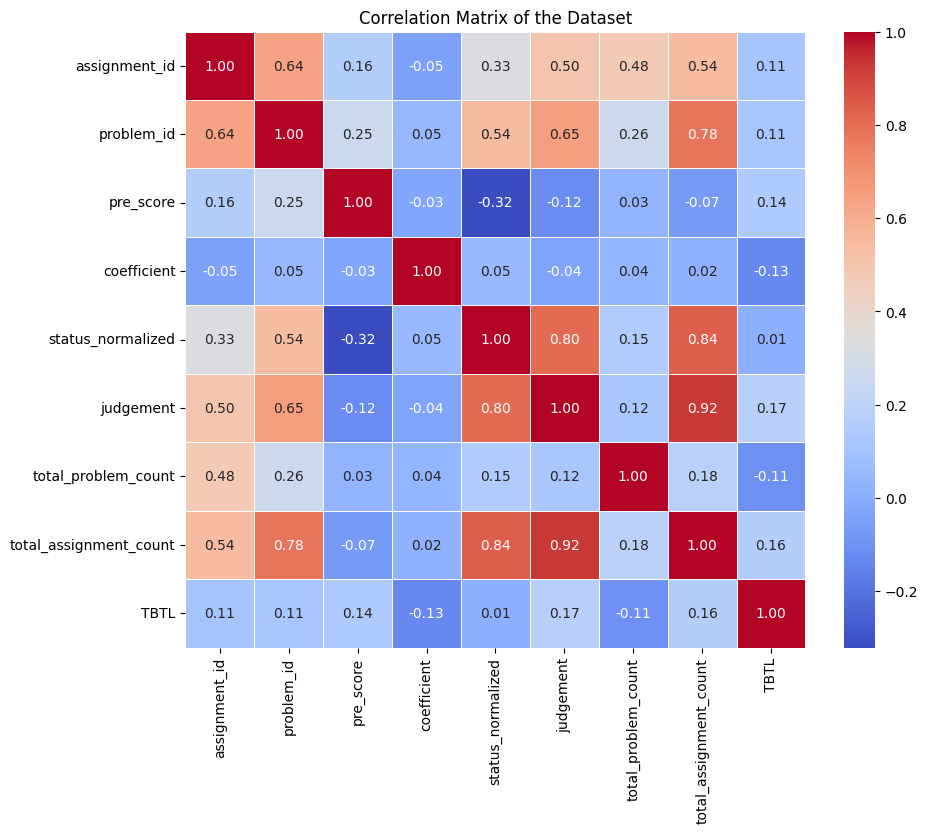

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans

shift_value = 100

# grouped_data['log_problem_id'] = grouped_data['total_problem_count'] * grouped_data['problem_id'] * grouped_data['judgement']

grouped_data['pre_score'] = grouped_data['pre_score'] / 100
grouped_data['total_assignment_count'] = grouped_data['total_assignment_count'] / 2
grouped_data['total_problem_count'] = grouped_data['total_problem_count'] / 5

train_data_new = grouped_data.copy()

train_data_new['TBTL'] = pd.to_numeric(train_data_new['TBTL'], errors='coerce')

correlation_matrix = train_data_new.drop(columns="username").corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of the Dataset')
plt.show()

In [33]:
grouped_data.columns

Index(['username', 'assignment_id', 'problem_id', 'pre_score', 'coefficient',
       'status_normalized', 'judgement', 'total_problem_count',
       'total_assignment_count', 'TBTL'],
      dtype='object')

In [34]:
train_data = grouped_data.dropna(subset=['TBTL']).copy()
features = ['assignment_id', 'problem_id', 'pre_score', 'judgement', 'total_assignment_count','total_problem_count' , 'coefficient' , 'status_normalized']

X = train_data[features]
y = train_data['TBTL']

print(y.unique())
y = y.replace({'\xa0': 0, '': 0}, regex=True)  
y = y.astype(float)  

[7.24 8.11 7.3  8.63 8.2  7.5  6.42 7.23 7.34 8.59 7.41 8.8  8.01 8.6
 7.62 7.02 8.19 9.04 8.41 8.7  8.18 8.42 8.76 7.61 8.58 8.3  8.29 8.02
 8.32 6.6  8.86 7.89 9.13 7.28 7.97 7.56 8.71 8.5  7.93 7.81 6.77 7.64
 7.6  7.65 6.81 6.27 8.87 8.66 8.75 9.28 8.15 7.96 6.67 8.93 6.87 9.2
 8.34 7.83 9.   8.72 8.54 7.31 8.84 7.11 7.38 6.41 8.51 6.89 8.17 6.93
 9.07 8.53 7.17 7.7  5.89 8.43 7.21 8.65 8.94 7.82 6.61 6.43 2.52 8.1
 6.26 8.31 8.82 6.37 8.67 8.79 7.74 8.33 6.82 9.19 6.06 6.57 7.91 6.08
 8.99 7.78 7.66 7.19 8.44 8.69 6.46 7.25 7.48 8.52 7.08 8.06 7.54 8.
 7.59 7.22 8.4  7.33 7.49 6.68 7.8  8.07 8.38 8.12 7.09 7.44 6.09 7.51
 8.83 8.23 8.85 9.59 8.14 9.53 7.42 7.86 7.63 9.16 8.24 7.94 7.73 6.98
 8.35 6.34 8.56 8.37 7.72 6.58 7.07 8.39 7.26 6.95 8.09 7.92 7.67 8.73
 7.39 7.84 6.65 7.68 7.76 7.71 6.23 6.49 7.14 8.13 7.69 7.45 9.06 8.74
 6.66 7.43 6.25 8.04 6.38 8.27 7.79 7.1  8.03 9.29 6.84 2.56 9.15 8.61
 8.28 6.79 8.97 7.16 8.64 6.76 9.63 7.12 6.18 9.02 8.46 7.04 7.46 7.77
 9.17 8.81 

In [35]:
y.shape

(799,)

In [36]:
X

,assignment_id,problem_id,pre_score,judgement,total_assignment_count,total_problem_count,coefficient,status_normalized
0,7,46,55.041497,72,73.5,64.2,100.000000,28
1,9,78,54.885521,107,129.5,409.8,100.000000,50
2,7,66,59.737538,95,97.5,42.4,100.000000,20
3,4,47,59.527600,42,50.0,256.0,100.000000,24
4,8,52,64.744486,38,53.5,411.4,97.196262,13
...,...,...,...,...,...,...,...,...
796,6,43,51.716396,50,55.5,74.0,100.000000,30
797,17,104,47.852241,125,178.5,1422.8,100.000000,103
798,8,52,42.472968,61,77.5,1422.8,100.000000,38
799,12,114,42.786050,224,278.5,187.6,100.000000,141


In [37]:
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = CatBoostRegressor(verbose=0)

model.fit(X_train, y_train)

In [38]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = ((y_test - y_pred) ** 2).mean()

print(f"Đánh giá hiệu năng mô hình:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

Đánh giá hiệu năng mô hình:
Mean Absolute Error (MAE): 0.6834
R-squared (R²): 0.1069
Mean Squared Error (MSE): 0.6950


In [39]:
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold

model = CatBoostRegressor(verbose=0)

model.fit(X, y)

In [40]:
data_to_predict = grouped_data[grouped_data['TBTL'].isna()]

X_to_predict = data_to_predict[features]
data_to_predict.loc[:, 'TBTL'] = model.predict(X_to_predict)

In [41]:
output = data_to_predict[['username', 'TBTL']]
output['TBTL'] = output['TBTL'].astype(float).round(2)

output

C:\Users\Admin\AppData\Local\Temp\ipykernel_2648\1298611124.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['TBTL'] = output['TBTL'].astype(float).round(2)


,username,TBTL
394,410357eb9129023509cfaf8d38be61c050bb3b05,8.13
625,67212308d026508fd5b6942ffbbdd7b0be2e89de,8.14
801,84a17972cc6d29489bbe205a9e7feb8745726fbc,7.73
802,84b6b2d70924066c8345f2bc2281791ae3188da2,7.35
803,851d9a4b9b8e236f2d62282ddf06fae57b7d9492,7.99
...,...,...
1484,feb8a2859a011c59efd22ed419cb69288fe03627,8.50
1485,fef4a3263ed9a8ab14d457694bb8fd86ccd98312,7.75
1486,ff12d6e2ab80696ed8e22fbe5497e96c68d29076,8.17
1487,ff3fa2ec64294f37ae968159f810ebeda7966c51,7.07


In [42]:
output.to_csv("predicted_TBTL_for_new_users.csv", index=False, header=False)

print("Kết quả dự đoán đã được lưu vào predicted_TBTL_for_new_users.csv")

Kết quả dự đoán đã được lưu vào predicted_TBTL_for_new_users.csv
